In [1]:
import numpy as np
import pandas as pd
import sys
import csv
from string import punctuation, digits
import random
from matplotlib import pyplot as plt

# Contents:
## 1. Functions
## 2. Data preparation
## 3. Build classifiers
## 4. Remove or keep stop words
## 5. Change binary features to counts features

# Part 1 - Functions

## 1.1 - Importing Data

In [2]:
def load_data(path_data, extras=False):
    if sys.version_info[0] < 3:
        PYTHON3 = False
    else:
        PYTHON3 = True

    basic_fields = {'sentiment', 'text'}
    numeric_fields = {'sentiment', 'helpfulY', 'helpfulN'}

    data = []
    if PYTHON3:
        f_data = open(path_data, encoding="latin1")
    else:
        f_data = open(path_data)

    for datum in csv.DictReader(f_data, delimiter='\t'):
        for field in list(datum.keys()):
            if not extras and field not in basic_fields:
                del datum[field]
            elif field in numeric_fields and datum[field]:
                datum[field] = int(datum[field])

        data.append(datum)

    f_data.close()

    return data

## 1.2 - NLP data manipulation

In [3]:
def extract_words(text):
    """
    Helper function for `bag_of_words(...)`.
    Args:
        a string `text`.
    Returns:
        a list of lowercased words in the string, where punctuation and digits count as their own words.
    """
    for c in punctuation + digits:
        text = text.replace(c, ' ' + c + ' ')
    return text.lower().split()

**Example**

In [4]:
text = "Yesterday, the tomato in the salad started a revolution against lettuce."
extract_words(text)

['yesterday',
 ',',
 'the',
 'tomato',
 'in',
 'the',
 'salad',
 'started',
 'a',
 'revolution',
 'against',
 'lettuce',
 '.']

In [5]:
def bag_of_words(texts, remove_stopword):
    """
    Args:
        `texts` - a list of natural language strings.
    Returns:
        a dictionary that maps each word appearing in `texts` to a unique integer `index`.
    """
    
    indices_by_word = {}  # maps word to unique index
    
    if remove_stopword == False:
        stopwords = []
    else:
        with open("stopwords.txt",'r',encoding='utf8') as stoptext:
            stopwords = stoptext.read()
            stopwords = stopwords.replace("\n"," ").split()

    for text in texts:
        word_list = extract_words(text)
        for word in word_list:
            if word in indices_by_word: continue
            if word in stopwords: continue
            indices_by_word[word] = len(indices_by_word)
            
    return indices_by_word

**Example**

In [6]:
corpus = ['This is the first document',
          'This document is the second document',
          'And this is the third one',
          'Is this the first document']

In [7]:
##### remove_stopword = True
bag_of_words(texts=corpus, remove_stopword=True)

{'first': 0, 'document': 1, 'second': 2, 'third': 3, 'one': 4}

In [8]:
##### remove_stopword = False
bag_of_words(texts=corpus, remove_stopword=False)

{'this': 0,
 'is': 1,
 'the': 2,
 'first': 3,
 'document': 4,
 'second': 5,
 'and': 6,
 'third': 7,
 'one': 8}

In [9]:
def extract_bow_feature_vectors(reviews, indices_by_word, binarize=True):
    """
    Args:
        `reviews` - a list of natural language strings
        `indices_by_word` - a dictionary of uniquely-indexed words.
    Returns:
        a matrix representing each review via bag-of-words features.  This
        matrix thus has shape (n, m), where n counts reviews and m counts words
        in the dictionary.
    """
    # Your code here
    feature_matrix = np.zeros([len(reviews), len(indices_by_word)], dtype=np.float64)
    for i, text in enumerate(reviews):
        word_list = extract_words(text)
        for word in word_list:
            if word not in indices_by_word: continue

            if binarize == False:
               feature_matrix[i, indices_by_word[word]] = word_list.count(word)
            else:
               feature_matrix[i, indices_by_word[word]] = 1

    return feature_matrix

**This function create the model development dataset. Every row represents a review, and every column represents a word in the vocabulary.**

**Example**

In [10]:
corpus = ['This is the first document',
          'This document is the second document',
          'And this is the third one',
          'Is this the first document']
vocabulary_with_stopword = bag_of_words(texts=corpus, remove_stopword=False)
vocabulary_no_stopword   = bag_of_words(texts=corpus, remove_stopword=True)

In [11]:
vocabulary_with_stopword

{'this': 0,
 'is': 1,
 'the': 2,
 'first': 3,
 'document': 4,
 'second': 5,
 'and': 6,
 'third': 7,
 'one': 8}

In [12]:
vocabulary_no_stopword

{'first': 0, 'document': 1, 'second': 2, 'third': 3, 'one': 4}

#### Case 1:
- Do not consider stop words - **indices_by_word=vocabulary_no_stopword**
- Return 0 or 1 that indicate whether the word appear in the vocabulary - **binarize=True**
- In the example below, in the first text, represented by the first row, the first and the second word in the vocabulary_no_stopword appear. 
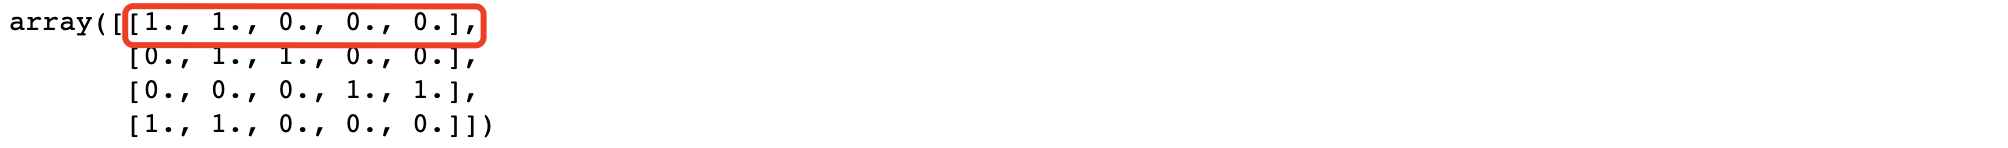

In [13]:
extract_bow_feature_vectors(reviews=corpus, 
                            indices_by_word=vocabulary_no_stopword, 
                            binarize=True)

array([[1., 1., 0., 0., 0.],
       [0., 1., 1., 0., 0.],
       [0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0.]])

#### Case 2:
- Do not consider stop words - **indices_by_word=vocabulary_with_stopword**
- Return the number of times z word appears in the vocabulary - **binarize=False**
- In the example below, in the second text, represented by the second row, the 1st, 2nd, 3rd, 5th, and 6th word in the appear. Also the fifth words "document" appear twice.
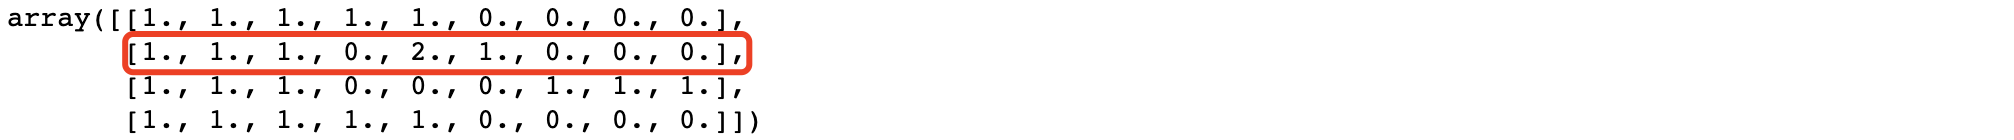

In [14]:
extract_bow_feature_vectors(reviews=corpus, 
                            indices_by_word=vocabulary_with_stopword, 
                            binarize=False)

array([[1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 0., 2., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0.]])

## 1.3 - Classifiers

### 1. [Perceptron Algorithm](https://en.wikipedia.org/wiki/Perceptron)
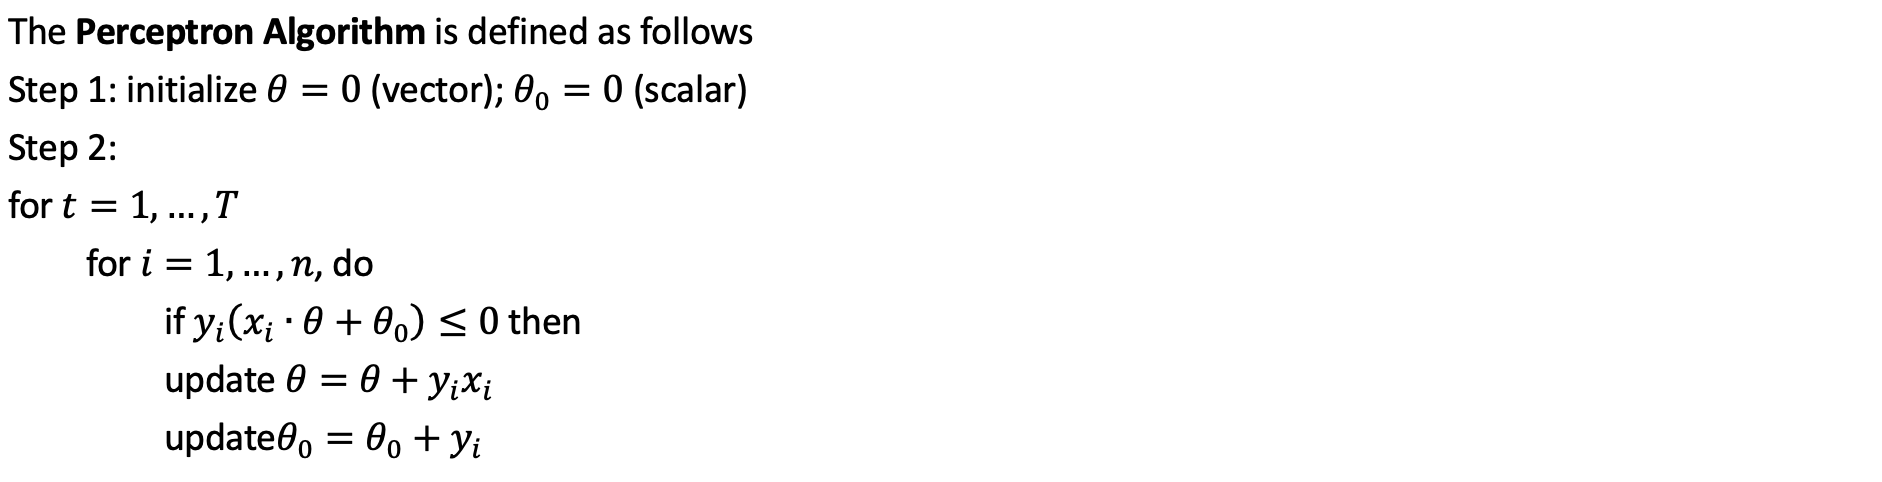

In [15]:
def get_order(n_samples,use_txt):
    """
    Helper function for `perceptron(...)`.
    Specifies the order for the iteration in Perceptron Algorithm
    """
    if use_txt:
        with open(str(n_samples) + '.txt') as fp:
            line = fp.readline()
            return list(map(int, line.split(',')))
    else:
        #random.seed(1)
        indices = list(range(n_samples))
        random.shuffle(indices)
        return indices

def perceptron_single_step_update(feature_vector, label, current_theta, current_theta_0):
    if label * (np.dot(current_theta, feature_vector) + current_theta_0) <= 1e-7:
        return (current_theta + label * feature_vector, current_theta_0 + label)
    return (current_theta, current_theta_0) 
    
def perceptron(feature_matrix, labels, T):
    n_observations  = feature_matrix.shape[0]
    n_features      = feature_matrix.shape[1]
    
    current_theta   = np.zeros(n_features)
    current_theta_0 = 0.0
  
    for t in range(T):
        for i in get_order(n_observations,True):
            current_theta, current_theta_0 = perceptron_single_step_update(feature_matrix[i,:], 
                                                                           labels[i], 
                                                                           current_theta, 
                                                                           current_theta_0)
    return (current_theta, current_theta_0)


### 2. Average Perceptron Algorithm
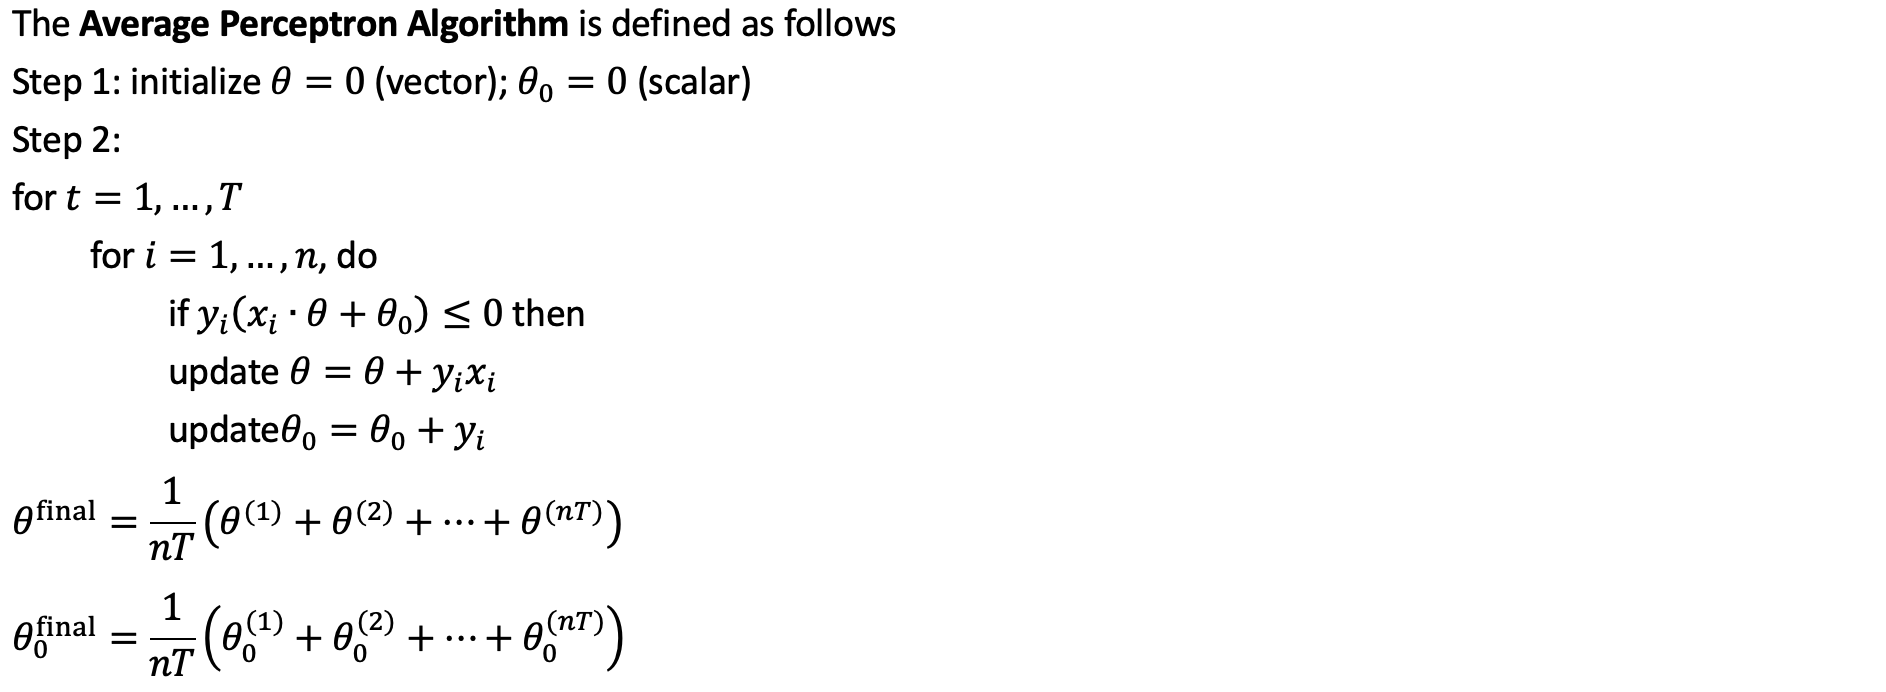

In [16]:
def average_perceptron(feature_matrix, labels, T):
    
    n_observations  = feature_matrix.shape[0]
    n_features      = feature_matrix.shape[1]
    
    current_theta   = np.zeros(n_features)
    current_theta_0 = 0.0
    
    cum_sum_beta    = 0.0
    cum_sum_beta_0  = 0.0
    
    for t in range(T):
        for i in get_order(n_observations,True):
            current_theta, current_theta_0 = perceptron_single_step_update(feature_matrix[i,:],
                                                                           labels[i], 
                                                                           current_theta, 
                                                                           current_theta_0)
            cum_sum_beta   += current_theta
            cum_sum_beta_0 += current_theta_0
            
    final_theta   = cum_sum_beta/(n_observations*T)
    final_theta_0 = cum_sum_beta_0/(n_observations*T)
    
    return final_theta, final_theta_0

### 3. Pegasos Algorithm
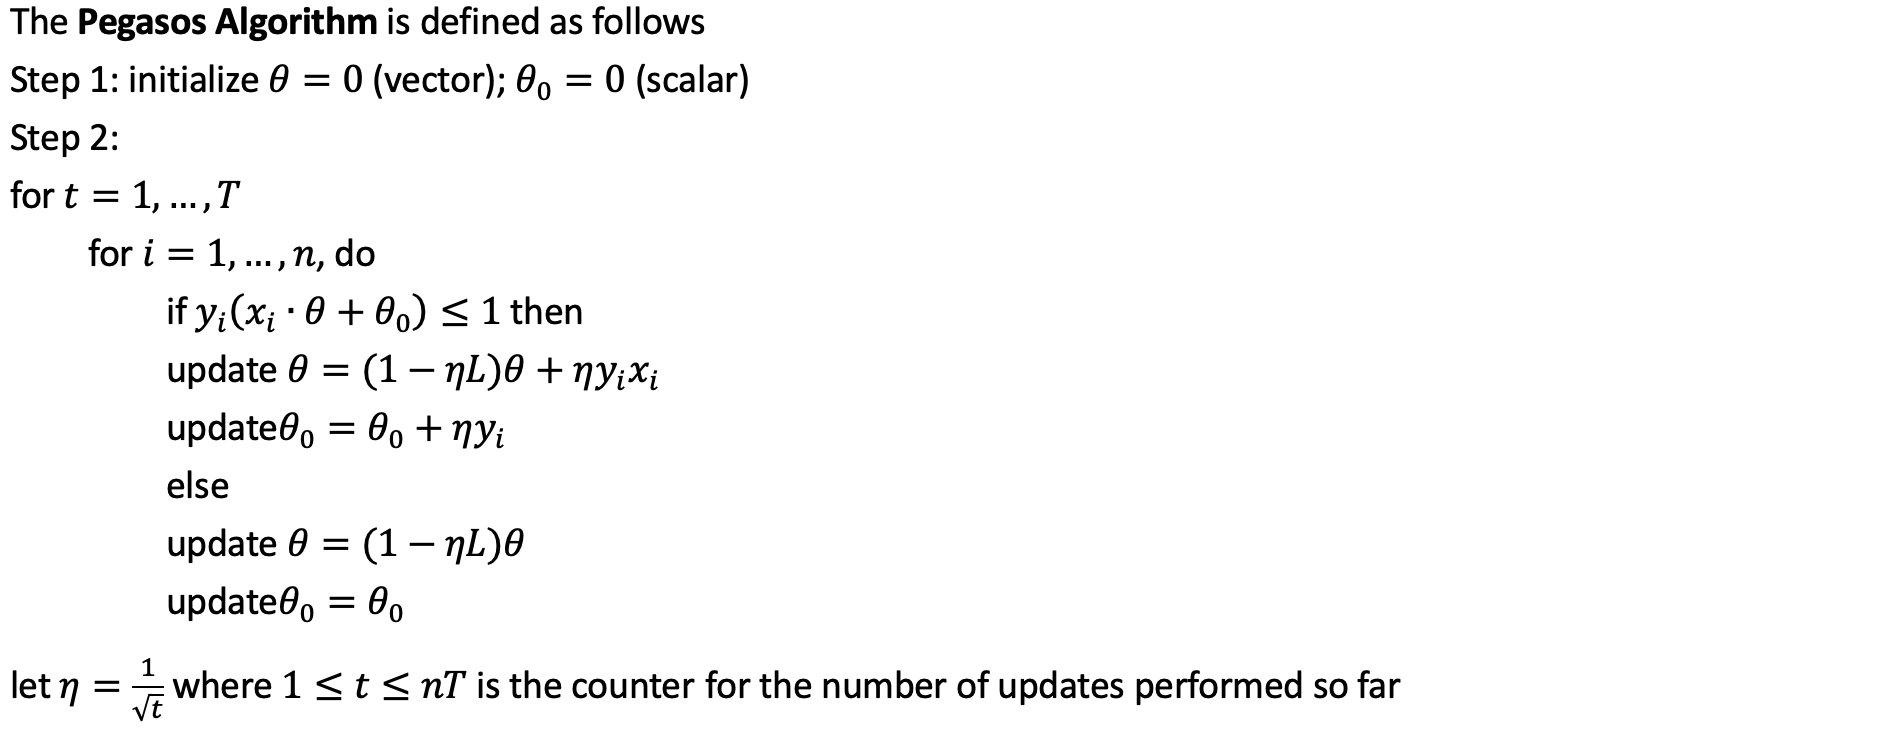

In [17]:
def pegasos_single_step_update(feature_vector,label,L,eta,current_theta,current_theta_0):
    temp = float(label*(current_theta.dot(feature_vector) + current_theta_0))
    
    if temp <=1.0:
        updated_theta   = current_theta*(1-L*eta) + eta*label*feature_vector
        updated_theta_0 = current_theta_0 + eta*label
    else:
        updated_theta   = current_theta*(1-eta*L)
        updated_theta_0 = current_theta_0
            
    return updated_theta,updated_theta_0


def pegasos(feature_matrix, labels, T, L):
    
    n_observations  = feature_matrix.shape[0]
    n_features      = feature_matrix.shape[1]
    
    current_theta   = np.zeros(n_features)
    current_theta_0 = 0.0
    
    counter = 0
    
    for t in range(T):
        for i in get_order(n_observations,True):
            counter+=1
            eta = 1/np.sqrt(counter)
            current_theta, current_theta_0 = pegasos_single_step_update(feature_matrix[i,:],labels[i],
                                                                        L, 
                                                                        eta,
                                                                        current_theta,
                                                                        current_theta_0)
    return (current_theta, current_theta_0)

## 1.4 - Tuning hyperparameters

### 1. Tuning "T" in the Perceptron Algorithm

In [18]:
def tuning_perceptron_T(Ts,
                        train_features,val_features,
                        train_labels,val_labels,
                        create_plot):
    tuning_df      = pd.DataFrame(columns=['T','train_accuracy','val_accuracy'])
    tuning_df['T'] = Ts
    for i,t_value in enumerate(Ts):
        train_temp, val_temp = classifier_accuracy(perceptron,
                                                   train_features,val_features,
                                                   train_labels,val_labels,
                                                   T=t_value)
        tuning_df.loc[i,'train_accuracy'] = train_temp
        tuning_df.loc[i,'val_accuracy']   = val_temp
    if create_plot:
        plt.plot(tuning_df['T'],tuning_df['train_accuracy'],'-o')
        plt.plot(tuning_df['T'],tuning_df['val_accuracy'],'-o')
        plt.legend(['train','val'], loc='upper right', title='Partition')
        plt.show()
        
    return tuning_df

### 2. Tuning "T" in the Average Perceptron Algorithm

In [19]:
def tuning_average_perceptron_T(Ts,
                                train_features,val_features,
                                train_labels,val_labels,
                                create_plot):
    tuning_df      = pd.DataFrame(columns=['T','train_accuracy','val_accuracy'])
    tuning_df['T'] = Ts
    for i,t_value in enumerate(Ts):
        train_temp, val_temp = classifier_accuracy(average_perceptron,
                                                   train_features,val_features,
                                                   train_labels,val_labels,
                                                   T=t_value)
        tuning_df.loc[i,'train_accuracy'] = train_temp
        tuning_df.loc[i,'val_accuracy']   = val_temp
    if create_plot:
        plt.plot(tuning_df['T'],tuning_df['train_accuracy'],'-o')
        plt.plot(tuning_df['T'],tuning_df['val_accuracy'],'-o')
        plt.legend(['train','val'], loc='upper right', title='Partition')
        plt.show()
        
    return tuning_df

### 3. Tuning "T" and "L" (separately) in the Pegasos Algorithm

In [20]:
def tuning_pegasos_T(Ts,fixed_L,
                     train_features,val_features,
                     train_labels,val_labels,
                     create_plot):
    tuning_df      = pd.DataFrame(columns=['T','train_accuracy','val_accuracy'])
    tuning_df['T'] = Ts
    for i,t_value in enumerate(Ts):
        train_temp, val_temp = classifier_accuracy(pegasos,
                                                   train_features,val_features,
                                                   train_labels,val_labels,
                                                   T=t_value,L=fixed_L)
        tuning_df.loc[i,'train_accuracy'] = train_temp
        tuning_df.loc[i,'val_accuracy']   = val_temp
    if create_plot:
        plt.plot(tuning_df['T'],tuning_df['train_accuracy'],'-o')
        plt.plot(tuning_df['T'],tuning_df['val_accuracy'],'-o')
        plt.legend(['train','val'], loc='upper right', title='Partition')
        plt.show()
        
    return tuning_df

def tuning_pegasos_L(Ls,fixed_T,
                     train_features,val_features,
                     train_labels,val_labels,
                     create_plot):
    tuning_df      = pd.DataFrame(columns=['L','train_accuracy','val_accuracy'])
    tuning_df['L'] = Ls
    for i,l_value in enumerate(Ls):
        train_temp, val_temp = classifier_accuracy(pegasos,
                                                   train_features,val_features,
                                                   train_labels,val_labels,
                                                   T=fixed_T,L=l_value)
        tuning_df.loc[i,'train_accuracy'] = train_temp
        tuning_df.loc[i,'val_accuracy']   = val_temp
    if create_plot:
        plt.plot(tuning_df['L'],tuning_df['train_accuracy'],'-o')
        plt.plot(tuning_df['L'],tuning_df['val_accuracy'],'-o')
        plt.legend(['train','val'], loc='upper right', title='Partition')
        plt.show()
        
    return tuning_df

## 1.5 - Linear classifier with given theta and theta0 (obtained through algorithms defined in 1.4)
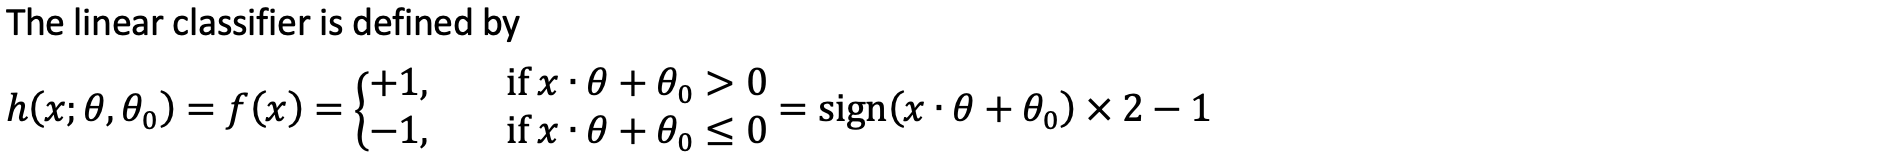

In [21]:
def classify(feature_matrix, theta, theta_0):
    return (feature_matrix @ theta + theta_0 > 1e-7) * 2.0 - 1

**Example**

In [22]:
feature_matrix = np.random.uniform(-1, 1, (10, 5))
theta          = np.random.uniform(-1, 1, (5, 1))
theta_0        = np.random.normal(0,1)

In [23]:
classify(feature_matrix,theta,theta_0)

array([[-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.]])

In [24]:
feature_matrix@theta+theta_0

array([[-0.33075681],
       [-1.97206168],
       [-0.56631103],
       [-1.46210686],
       [-0.10243391],
       [-1.70760639],
       [-1.46590415],
       [ 0.10585777],
       [-1.14042978],
       [-0.60671324]])

## 1.6 Accuracy of a classifier

In [25]:
def accuracy(preds, targets):
        return (preds == targets).mean()
    
def classifier_accuracy(classifier,
                        train_feature_matrix,
                        val_feature_matrix,
                        train_labels,
                        val_labels,
                        **kwargs):
    theta,theta_0     = classifier(train_feature_matrix, train_labels, **kwargs)
    train_predictions = classify(train_feature_matrix, theta, theta_0)
    val_predictions   = classify(val_feature_matrix, theta, theta_0)
    train_accuracy    = accuracy(train_predictions, train_labels)
    val_accuracy      = accuracy(val_predictions, val_labels)
    return train_accuracy, val_accuracy

# Part 2 - Data Preparation

In [26]:
train_data = load_data('reviews_train.tsv')
val_data   = load_data('reviews_val.tsv')
test_data  = load_data('reviews_test.tsv')

In [27]:
train_data[:3]

[{'sentiment': -1,
  'text': 'The chips are okay Not near as flavorful as the regular blue chips. Nice size bag for a family.'},
 {'sentiment': -1,
  'text': 'I had high hopes for this, but it was bad.  Really bad.  The whole pan of cupcakes made from this had to be thrown out.  Very gritty and dense.'},
 {'sentiment': -1,
  'text': "I guess it's only one can since there is nothing in the description about how many cans you get. I guess we can't all be intelligent."}]

In [28]:
train_texts, train_labels = zip(*((sample['text'], sample['sentiment']) for sample in train_data))
val_texts, val_labels     = zip(*((sample['text'], sample['sentiment']) for sample in val_data))
test_texts, test_labels   = zip(*((sample['text'], sample['sentiment']) for sample in test_data))

### Unzip the zipped list to a text list and a label list (using [zip( )](https://www.programiz.com/python-programming/methods/built-in/zip) function)

In [29]:
train_texts, train_labels = zip(*((sample['text'], sample['sentiment']) for sample in train_data))
val_texts, val_labels     = zip(*((sample['text'], sample['sentiment']) for sample in val_data))
test_texts, test_labels   = zip(*((sample['text'], sample['sentiment']) for sample in test_data))

In [30]:
dictionary_remove_stopwords = bag_of_words(texts=train_texts,remove_stopword=True)
dictionary_keep_stopwords   = bag_of_words(texts=train_texts,remove_stopword=False)

### Create features

In [31]:
train_features_keep_stopwords   = extract_bow_feature_vectors(train_texts, dictionary_keep_stopwords)
val_features_keep_stopwords     = extract_bow_feature_vectors(val_texts, dictionary_keep_stopwords)
test_features_keep_stopwords    = extract_bow_feature_vectors(test_texts, dictionary_keep_stopwords)

train_features_remove_stopwords = extract_bow_feature_vectors(train_texts, dictionary_remove_stopwords)
val_features_remove_stopwords   = extract_bow_feature_vectors(val_texts, dictionary_remove_stopwords)
test_features_remove_stopwords  = extract_bow_feature_vectors(test_texts, dictionary_remove_stopwords)

# Part 3 - Build Classifiers

## 3.1 Perceptron classifier

In [32]:
T = 10
pct_train_accuracy, pct_val_accuracy = classifier_accuracy(perceptron,
                                                           train_features_keep_stopwords,
                                                           val_features_keep_stopwords,
                                                           train_labels,
                                                           val_labels,T=T)

In [33]:
print('Training accuracy for perceptron:', pct_train_accuracy)
print('Validation accuracy for perceptron:', pct_val_accuracy)

Training accuracy for perceptron: 0.81575
Validation accuracy for perceptron: 0.716


### Different order of observations used in the iterations leads to different resutls.
- #### In the following code, get_order(.) function with "use_txt=False" creates an order by random shuffling. 
- #### Going forward, use a fixed order stored in an txt file. 

In [34]:
def perceptron_temp(feature_matrix, labels, T):
    n_observations  = feature_matrix.shape[0]
    n_features      = feature_matrix.shape[1]
    
    current_theta   = np.zeros(n_features)
    current_theta_0 = 0.0
  
    for t in range(T):
        for i in get_order(n_observations,False):
            current_theta, current_theta_0 = perceptron_single_step_update(feature_matrix[i,:], 
                                                                           labels[i], 
                                                                           current_theta, 
                                                                           current_theta_0)
    return (current_theta, current_theta_0)


In [35]:
for i in range(10):
    pct_train_accuracy, pct_val_accuracy = classifier_accuracy(perceptron_temp,
                                                               train_features_keep_stopwords,
                                                               val_features_keep_stopwords,
                                                               train_labels,
                                                               val_labels,T=T)
    print(pct_train_accuracy, pct_val_accuracy)

0.97225 0.762
0.965 0.78
0.976 0.786
0.9835 0.786
0.9685 0.766
0.97675 0.756
0.973 0.782
0.9395 0.772
0.9565 0.776
0.94525 0.75


### Tuning "T" in the Perceptron algorithm

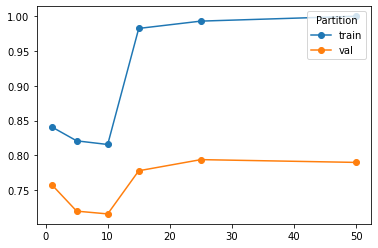

,T,train_accuracy,val_accuracy
0,1,0.841,0.758
1,5,0.821,0.72
2,10,0.81575,0.716
3,15,0.9825,0.778
4,25,0.993,0.794
5,50,1.0,0.79


In [36]:
Ts = [1, 5, 10, 15, 25, 50]
tuning_T_perceptron = tuning_perceptron_T(Ts,
                                          train_features_keep_stopwords,val_features_keep_stopwords,
                                          train_labels,val_labels,
                                          True)
tuning_T_perceptron

## 3.2 Average Perceptron classifier

In [37]:
T = 10
avg_pct_train_accuracy, avg_pct_val_accuracy = classifier_accuracy(average_perceptron,
                                                                   train_features_keep_stopwords,
                                                                   val_features_keep_stopwords,
                                                                   train_labels,
                                                                   val_labels,T=T)

In [38]:
print('Training accuracy for average perceptron:', avg_pct_train_accuracy)
print('Validation accuracy for average perceptron:', avg_pct_val_accuracy)

Training accuracy for average perceptron: 0.97275
Validation accuracy for average perceptron: 0.798


### Tuning T in the Average Perceptron algorithm

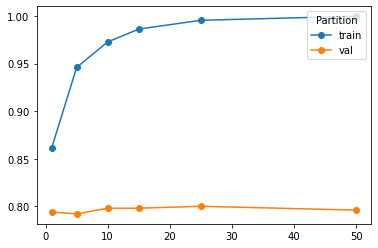

,T,train_accuracy,val_accuracy
0,1,0.86175,0.794
1,5,0.946,0.792
2,10,0.97275,0.798
3,15,0.98625,0.798
4,25,0.9955,0.8
5,50,0.99975,0.796


In [39]:
Ts = [1, 5, 10, 15, 25, 50]
tuning_T_average_perceptron = tuning_average_perceptron_T(Ts,
                                                          train_features_keep_stopwords,
                                                          val_features_keep_stopwords,
                                                          train_labels,
                                                          val_labels,
                                                          True)
tuning_T_average_perceptron

## 3.3 Pegasos classifier

In [40]:
L = 0.01
T = 10 
peg_train_accuracy, peg_val_accuracy = classifier_accuracy(pegasos, 
                                                           train_features_keep_stopwords,
                                                           val_features_keep_stopwords,
                                                           train_labels,
                                                           val_labels,
                                                           T=T,
                                                           L=L)
print('Training accuracy for pegasos:', peg_train_accuracy)
print('Validation accuracy for pegasos:', peg_val_accuracy)

Training accuracy for pegasos: 0.91425
Validation accuracy for pegasos: 0.79


### Tuning "T" in the Pegasos algorithm

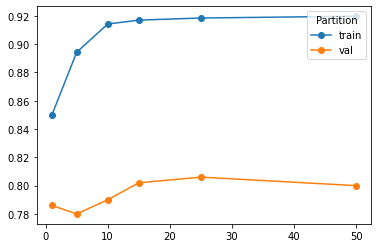

,T,train_accuracy,val_accuracy
0,1,0.841,0.758
1,5,0.821,0.72
2,10,0.81575,0.716
3,15,0.9825,0.778
4,25,0.993,0.794
5,50,1.0,0.79


In [41]:
Ts = [1, 5, 10, 15, 25, 50]
fixed_L = 0.01
tuning_T_pegasos = tuning_pegasos_T(Ts,fixed_L,
                                    train_features_keep_stopwords,
                                    val_features_keep_stopwords,
                                    train_labels,val_labels,
                                    True)
tuning_T_perceptron

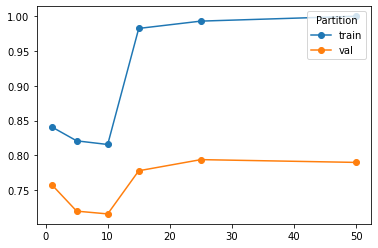

In [42]:
plt.plot(tuning_T_perceptron['T'],tuning_T_perceptron['train_accuracy'],'-o')
plt.plot(tuning_T_perceptron['T'],tuning_T_perceptron['val_accuracy'],'-o')
plt.legend(['train','val'], loc='upper right', title='Partition')
plt.show()

### Tuning "L" in the Pegasos algorithm, with "fixed_T = optimal T" obtained above

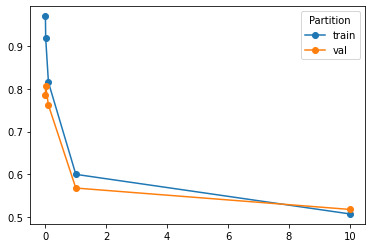

In [43]:
fixed_T = 25
Ls      = [0.001, 0.01, 0.1, 1, 10]
tuning_L_pegasos = tuning_pegasos_L(Ls,fixed_T,
                                    train_features_keep_stopwords,
                                    val_features_keep_stopwords,
                                    train_labels,val_labels,
                                    True)

### Comparing the acccurary vs T

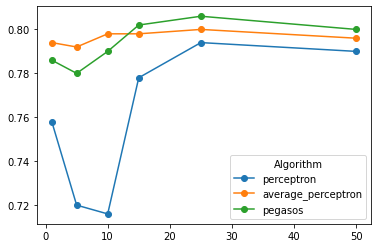

In [44]:
plt.plot(tuning_T_perceptron['T'],tuning_T_perceptron['val_accuracy'],'-o')
plt.plot(tuning_T_average_perceptron['T'],tuning_T_average_perceptron['val_accuracy'],'-o')
plt.plot(tuning_T_pegasos['T'],tuning_T_pegasos['val_accuracy'],'-o')
plt.legend(['perceptron','average_perceptron','pegasos'], loc='lower right', title='Algorithm')
plt.show()

# Part 4 - Remove or Keep Stop Words
### Now consider datasets with and without the stopwords.  
### Build models using different datasets and compare their accuracy. 

In [45]:
theta_per_keep, theta_0_per_keep           = perceptron(train_features_keep_stopwords, train_labels, 25)
theta_per_remove, theta_0_per_remove       = perceptron(train_features_remove_stopwords, train_labels, 25)
theta_avgper_keep, theta_0_avgper_keep     = average_perceptron(train_features_keep_stopwords,
                                                                train_labels, 25)
theta_avgper_remove, theta_0_avgper_remove = average_perceptron(train_features_remove_stopwords,
                                                                train_labels, 25)
theta_peg_keep, theta_0_peg_keep           = pegasos(train_features_keep_stopwords, train_labels, 25, 0.01)
theta_peg_remove, theta_0_peg_remove       = pegasos(train_features_remove_stopwords, train_labels, 25, 0.01)

In [46]:
per_keep_acc      = accuracy(classify(test_features_keep_stopwords, theta_per_keep, theta_0_per_keep),
                             test_labels)
per_remove_acc    = accuracy(classify(test_features_remove_stopwords, theta_per_remove, theta_0_per_remove),
                             test_labels)
avgper_keep_acc   = accuracy(classify(test_features_keep_stopwords, theta_avgper_keep, theta_0_avgper_keep),
                             test_labels)
avgper_remove_acc = accuracy(classify(test_features_remove_stopwords, theta_avgper_remove, theta_0_avgper_remove),
                             test_labels)
peg_keep_acc      = accuracy(classify(test_features_keep_stopwords, theta_peg_keep, theta_0_peg_keep),
                             test_labels)
peg_remove_acc    = accuracy(classify(test_features_remove_stopwords, theta_peg_remove, theta_0_peg_remove),
                             test_labels)

In [47]:
print('Testing accuracy for perceptron, keeping stopwords:', per_keep_acc)
print('Testing accuracy for perceptron, removing stopwords:', per_remove_acc)
print('Testing accuracy for average perceptron, keeping stopwords:', avgper_keep_acc)
print('Testing accuracy for average perceptron, removing stopwords:', avgper_remove_acc)
print('Testing accuracy for pegasos, keeping stopwords:', peg_keep_acc)
print('Testing accuracy for pegasos, removing stopwords:', peg_remove_acc)

Testing accuracy for perceptron, keeping stopwords: 0.808
Testing accuracy for perceptron, removing stopwords: 0.814
Testing accuracy for average perceptron, keeping stopwords: 0.818
Testing accuracy for average perceptron, removing stopwords: 0.814
Testing accuracy for pegasos, keeping stopwords: 0.802
Testing accuracy for pegasos, removing stopwords: 0.808


# Part 5 - Change Binary Features to Counts Features
### Previously, the features are binary. Now consider an alternative - the counts of appearance for each word in the vocabulary. Also removing stop words.

In [48]:
train_features_counts   = extract_bow_feature_vectors(train_texts, dictionary_remove_stopwords,False)
val_features_counts     = extract_bow_feature_vectors(val_texts, dictionary_remove_stopwords,False)
test_features_counts    = extract_bow_feature_vectors(test_texts, dictionary_remove_stopwords,False)

In [49]:
theta_per_count, theta_0_per_count       = perceptron(train_features_counts, train_labels, 25)
theta_avgper_count, theta_0_avgper_count = average_perceptron(train_features_counts,train_labels, 25)
theta_peg_count, theta_0_peg_count       = pegasos(train_features_counts, train_labels, 25, 0.01)

In [50]:
per_count_acc    = accuracy(classify(test_features_counts, theta_per_count, theta_0_per_count),
                             test_labels)
avgper_count_acc = accuracy(classify(test_features_counts, theta_avgper_count, theta_0_avgper_count),
                             test_labels)
peg_count_acc    = accuracy(classify(test_features_counts, theta_peg_count, theta_0_peg_count),
                             test_labels)

In [51]:
print('Testing accuracy for perceptron, removing stopwords, using binary:', per_remove_acc)
print('Testing accuracy for perceptron, removing stopwords, using counts:', per_count_acc)

print('Testing accuracy for average perceptron, removing stopwords, using binary:', avgper_remove_acc)
print('Testing accuracy for average perceptron, removing stopwords, using binary:', avgper_count_acc)

print('Testing accuracy for pegasos, removing stopwords, using binary:', peg_remove_acc)
print('Testing accuracy for pegasos, removing stopwords, using binary:', peg_count_acc)

Testing accuracy for perceptron, removing stopwords, using binary: 0.814
Testing accuracy for perceptron, removing stopwords, using counts: 0.758
Testing accuracy for average perceptron, removing stopwords, using binary: 0.814
Testing accuracy for average perceptron, removing stopwords, using binary: 0.788
Testing accuracy for pegasos, removing stopwords, using binary: 0.808
Testing accuracy for pegasos, removing stopwords, using binary: 0.77


#### The performance is getting worse after including the count information, for all the three algorithms. It indicates that the additional information causes overfitting.  